# Grid Searching to Determine the Number of Topics or Clusters

For anyone familiar with tuning hyperparameters in a SciKit Learn supervised model, you have probably used `GridSearchCV` to tune the best hyperparameters for your model. `GridSearchCV` works by essentially fitting a model for each of your combinations of hyperparameters and providing you with a cross-validated score for each combination of features. At the end of the process, you are able to determine which values of your hyperparameters result in the best score. 

Because I am using unsupervised learning techniques (KMeansClustering in SciKit Learn and Latent Dirichilet Allocation in Gensim) in this project, I am unable to use `GridSearchCV` to determine the optimal number of topics/clusters for my data. To overcome this, I have built functions to allow me to assess a metric score and topic composition for each number of clusters/topics. 

With unsupervised learning techniques, such as clustering, often the number that results in the best score might not be the most interpretable. Therefore, it will be important to make sure that any clusters or topics that emerge from the model also have clear meaning to the human that is evaluating them. **Here, we will appy these functions to the General Women's Health, Fertility and Pregancy, and Postpartum and Early Parenthood data to try and find clusters/topics that are not only optimized for a scoring metric but also interpretable.**

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Spacy
import spacy

# Scipy
import scipy.sparse

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Gensim
from gensim import matutils
from gensim import corpora
# from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# NLTK
from nltk.corpus import stopwords

# Silence Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Read-In Data

In [2]:
health = pd.read_csv('../data/womens_health_preprocessed.csv', lineterminator='\n')
print(f'Health Shape: {health.shape}')
obsgyn = pd.read_csv('../data/fertility_and_pregnancy_preprocessed.csv')
print(f'ObsGyn Shape: {obsgyn.shape}')
pospar = pd.read_csv('../data/postpartum_preprocessed.csv')
print(f'Pospar Shape: {pospar.shape}')

Health Shape: (30616, 7)
ObsGyn Shape: (92943, 7)
Pospar Shape: (49094, 7)


## Define Stop Words

In [3]:
def add_stop_words(word_list, list_stop_words):
    for word in word_list:
        list_stop_words.add(word)
        
def remove_stop_words(word_list, list_stop_words):
    for word in word_list:
        list_stop_words.remove(word)

In [4]:
# spaCy
nlp = spacy.load('en_core_web_sm')
stop_words_spacy = set(nlp.Defaults.stop_words)

# nltk
stop_words_nltk = set(stopwords.words('english'))

# full list of stop words
full_stop_words = stop_words_spacy.union(stop_words_nltk)

words_to_add = ['like', 'know', 'want', 'feel', 'going', 'think', 'reddit', 'imgur', 'pron', 'officially', 'story', 'month', 'week', 'time', 'day', 'year', 'delete', 'saturday', 'sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'subreddit']

add_stop_words(words_to_add, full_stop_words)
remove_stop_words(['not'], full_stop_words)

## Create Document Term Matrix (DTM) From Corpus

#### Function to Convert Text to a DTM

In [5]:
def build_tvec(df, column, stop_words = full_stop_words):
    tvec = TfidfVectorizer(max_df = 0.98, min_df = 0.005, ngram_range = (1,2), stop_words = stop_words)
    dtm = tvec.fit_transform(df[column])
    return tvec, dtm

#### Create DTM for Each Health Domain

In [6]:
# Vectorizer, dtm are outputed from build_tvec

health_vectorizer, health_dtm = build_tvec(health, 'lemma_text')
obsgyn_vectorizer, obsgyn_dtm = build_tvec(obsgyn, 'lemma_text')
pospar_vectorizer, pospar_dtm = build_tvec(pospar, 'lemma_text')


#### Transform DTM into a Term Document Matrix (TDM) That is Compatible with Gensim
**Note**: Code for these steps was modified from [A Dash of Data](https://github.com/adashofdata/nlp-in-python-tutorial) by Alice Zhao

***FOR GENSIM MODELS ONLY!*** 

In [7]:
def create_tdm(dtm):
    tdm = dtm.transpose() # transpose dtm
    return tdm

def tdm_to_gensim_corpus(tdm):
    sparse = scipy.sparse.csr_matrix(tdm) # Create a compressed sparse row matrix
    corpus = matutils.Sparse2Corpus(tdm) # Create a corpus from sparse matrix
    return corpus

def prepare_dtm_for_gensim(dtm):
    tdm = create_tdm(dtm)
    corpus = tdm_to_gensim_corpus(tdm)
    return corpus

#### Transform the DTM to TDM for Each Health Domain

In [8]:
health_corpus = prepare_dtm_for_gensim(health_dtm)
obsgyn_corpus = prepare_dtm_for_gensim(obsgyn_dtm)
pospar_corpus = prepare_dtm_for_gensim(pospar_dtm)

## Define the Vocabulary That Was Used in the Vectorizer

***For Gensim Models***

In [9]:
def create_vocab_dictionary(vectorizer):
    vocab_dictionary = dict((v,k) for k,v in vectorizer.vocabulary_.items())
    return vocab_dictionary

In [10]:
health_vocabulary = create_vocab_dictionary(health_vectorizer)
obsgyn_vocabulary = create_vocab_dictionary(obsgyn_vectorizer)
pospar_vocabulary = create_vocab_dictionary(pospar_vectorizer)

***For SciKit Learn Models***

In [11]:
health_terms = health_vectorizer.get_feature_names()
obsgyn_terms = obsgyn_vectorizer.get_feature_names()
pospar_terms = pospar_vectorizer.get_feature_names()

## Grid Search

### K-Means Clustering
#### Functions

In [12]:
def grid_search_kmeans(start, stop, step, dtm):
    
    silhouettes = []
    models = {}
    
    for i in range(start, stop, step):
        
        # Build KMeans Model
        kmeans = KMeans(n_clusters = i, random_state = 42, n_jobs = -1)
        kmeans.fit(dtm)
        models[i] = kmeans
        
        # Calculate Silhouette Score & Append to List
        preds = kmeans.fit_predict(dtm)
        sil_score = silhouette_score(dtm, preds)
        silhouettes.append(sil_score)
        
    return models, silhouettes

In [13]:
def plot_gs_results(start, stop, step, list_of_scores, title = None, x_label = None, y_label = None):
    plt.figure(figsize = (12, 8))
    sns.lineplot(x = range(start, stop, step), y = list_of_scores, linewidth = 2, color = '#B392AC')
    plt.title(title, fontdict = {'fontsize': 15}, pad = 8)
    plt.xlabel(x_label, fontdict = {'fontsize': 12}, labelpad = 8)
    plt.ylabel(y_label, fontdict = {'fontsize': 12}, labelpad = 8)
    plt.tight_layout();

In [14]:
def get_topic_terms_kmeans(model, k, terms, n_terms = 15):
# Code modified from # https://pythonprogramminglanguage.com/kmeans-text-clustering/

    sorted_centroids = model.cluster_centers_.argsort()[:, ::-1]
    
    topic_dictionary = {}
    for i in range(k):
        topics_list = []
        for index in sorted_centroids[i, :n_terms]:
                topics_list.append(terms[index])
        topic_dictionary[i] = topics_list
    
    return topic_dictionary

#### KMeans Grid Search for General Women's Health Data

In [15]:
health_kmeans_models, health_silhouettes = grid_search_kmeans(2, 25, 2, health_dtm)

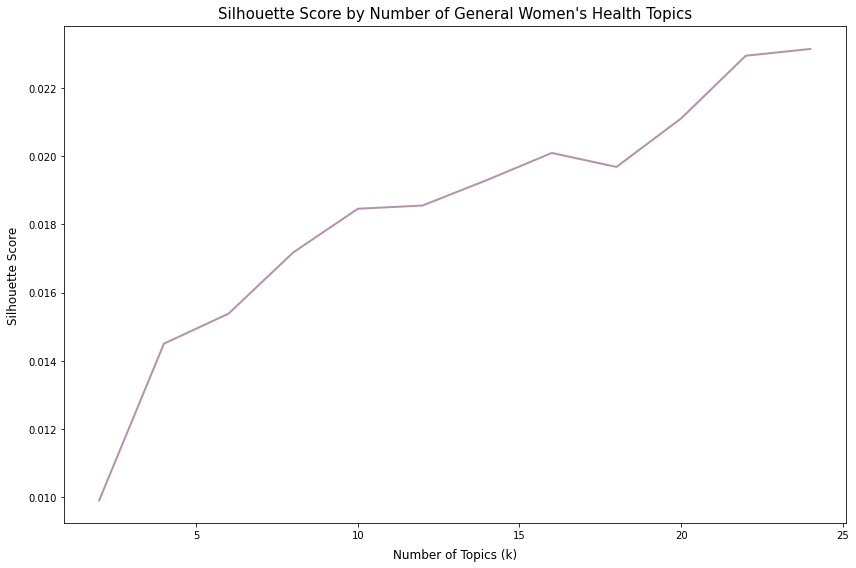

In [21]:
plot_gs_results(2, 25, 2, 
                health_silhouettes, 
                title = 'Silhouette Score by Number of General Women\'s Health Topics',
                x_label = 'Number of Topics (k)',
                y_label = 'Silhouette Score')

#### KMeans Grid Search for Fertility and Pregnancy Data

In [17]:
obsgyn_kmeans_models, obsgyn_silhouettes = grid_search_kmeans(2, 25, 2, obsgyn_dtm)

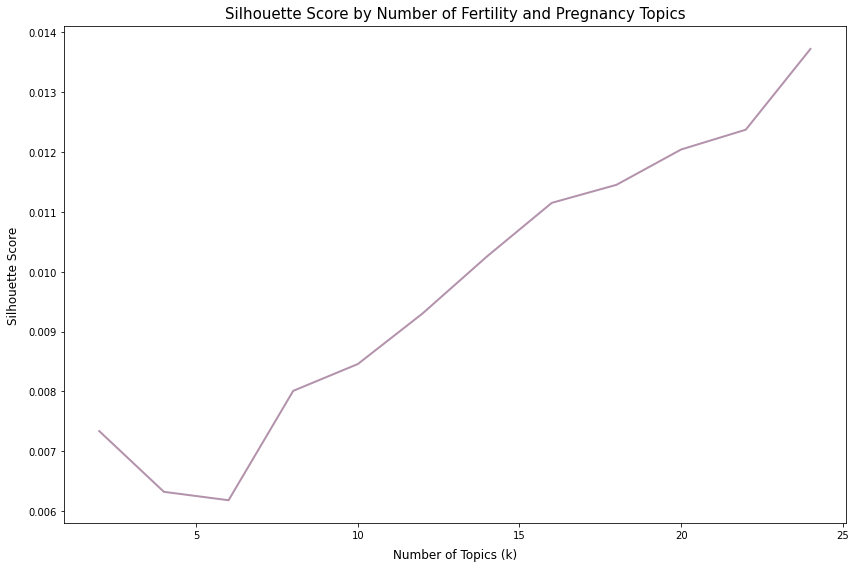

In [18]:
plot_gs_results(2, 25, 2, 
                obsgyn_silhouettes, 
                title = 'Silhouette Score by Number of Fertility and Pregnancy Topics',
                x_label = 'Number of Topics (k)',
                y_label = 'Silhouette Score')

#### KMeans Grid Search for Pospartum and Early Parenthood Data

In [19]:
pospar_kmeans_models, pospar_silhouettes = grid_search_kmeans(2, 25, 2, pospar_dtm)

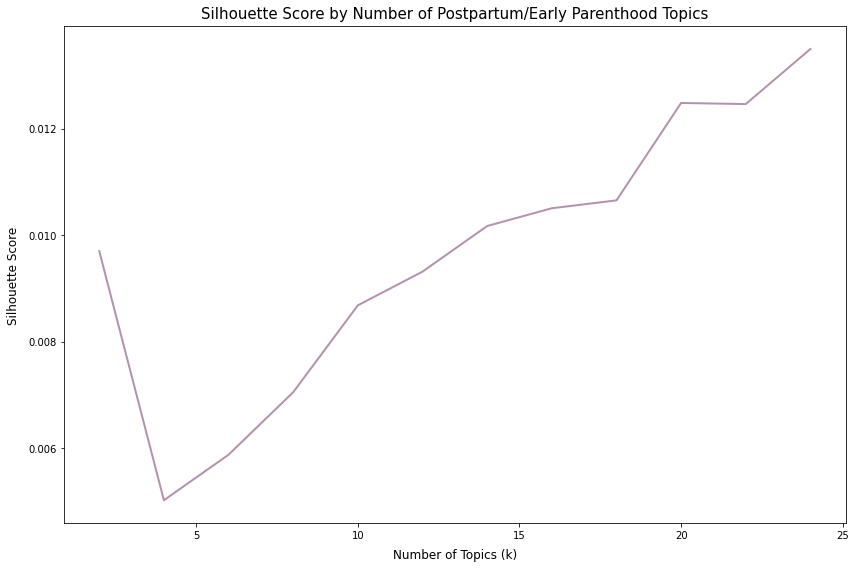

In [20]:
plot_gs_results(2, 25, 2, 
                pospar_silhouettes, 
                title = 'Silhouette Score by Number of Postpartum/Early Parenthood Topics',
                x_label = 'Number of Topics (k)',
                y_label = 'Silhouette Score')